In [3]:
!pip install -q kaggle

from google.colab import files
files.upload()  # Upload kaggle.json again

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d shubhamgoel27/dermnet --unzip -p ./dermnet_data

# ✅ Check if dataset is there
!ls ./dermnet_data
!ls ./dermnet_data/train


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/shubhamgoel27/dermnet
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
test  train
'Acne and Rosacea Photos'
'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions'
'Atopic Dermatitis Photos'
'Bullous Disease Photos'
'Cellulitis Impetigo and other Bacterial Infections'
'Eczema Photos'
'Exanthems and Drug Eruptions'
'Hair Loss Photos Alopecia and other Hair Diseases'
'Herpes HPV and other STDs Photos'
'Light Diseases and Disorders of Pigmentation'
'Lupus and other Connective Tissue diseases'
'Melanoma Skin Cancer Nevi and Moles'
'Nail Fungus and other Nail Disease'
'Poison Ivy Photos and other Contact Dermatitis'
'Psoriasis pictures Lichen Planus and related diseases'
'Scabies Lyme Disease and other Infestations and Bites'
'Seborrheic Keratoses and other Benign Tumors'
'Systemic Disease'
'Tinea Ringworm Candidiasis and other Fungal Infections'
'Urticaria Hiv

Using device: cuda
Classes: ['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Bullous Disease Photos', 'Cellulitis Impetigo and other Bacterial Infections', 'Eczema Photos', 'Exanthems and Drug Eruptions', 'Hair Loss Photos Alopecia and other Hair Diseases', 'Herpes HPV and other STDs Photos', 'Light Diseases and Disorders of Pigmentation', 'Lupus and other Connective Tissue diseases', 'Melanoma Skin Cancer Nevi and Moles', 'Nail Fungus and other Nail Disease', 'Poison Ivy Photos and other Contact Dermatitis', 'Psoriasis pictures Lichen Planus and related diseases', 'Scabies Lyme Disease and other Infestations and Bites', 'Seborrheic Keratoses and other Benign Tumors', 'Systemic Disease', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Urticaria Hives', 'Vascular Tumors', 'Vasculitis Photos', 'Warts Molluscum and other Viral Infections']


100%|██████████| 23/23 [18:20<00:00, 47.86s/it]


Saved features to train_X.npy


100%|██████████| 23/23 [04:42<00:00, 12.28s/it]


Saved features to test_X.npy
Train features: (15557, 1024), Test features: (4002, 1024)
Epoch 1/10, Loss: 2.3993, Train Acc: 29.61%
Epoch 2/10, Loss: 2.0179, Train Acc: 39.66%
Epoch 3/10, Loss: 1.8482, Train Acc: 44.30%
Epoch 4/10, Loss: 1.7194, Train Acc: 48.07%
Epoch 5/10, Loss: 1.6100, Train Acc: 50.83%
Epoch 6/10, Loss: 1.5167, Train Acc: 53.45%
Epoch 7/10, Loss: 1.4435, Train Acc: 55.53%
Epoch 8/10, Loss: 1.3686, Train Acc: 57.73%
Epoch 9/10, Loss: 1.3029, Train Acc: 59.49%
Epoch 10/10, Loss: 1.2333, Train Acc: 61.48%
Saved model to mlp_classifier.pt
Loaded model from mlp_classifier.pt
                                                                    precision    recall  f1-score   support

                                           Acne and Rosacea Photos       0.80      0.83      0.81       312
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions       0.57      0.68      0.62       288
                                          Atopic Dermatitis Photos       0.71

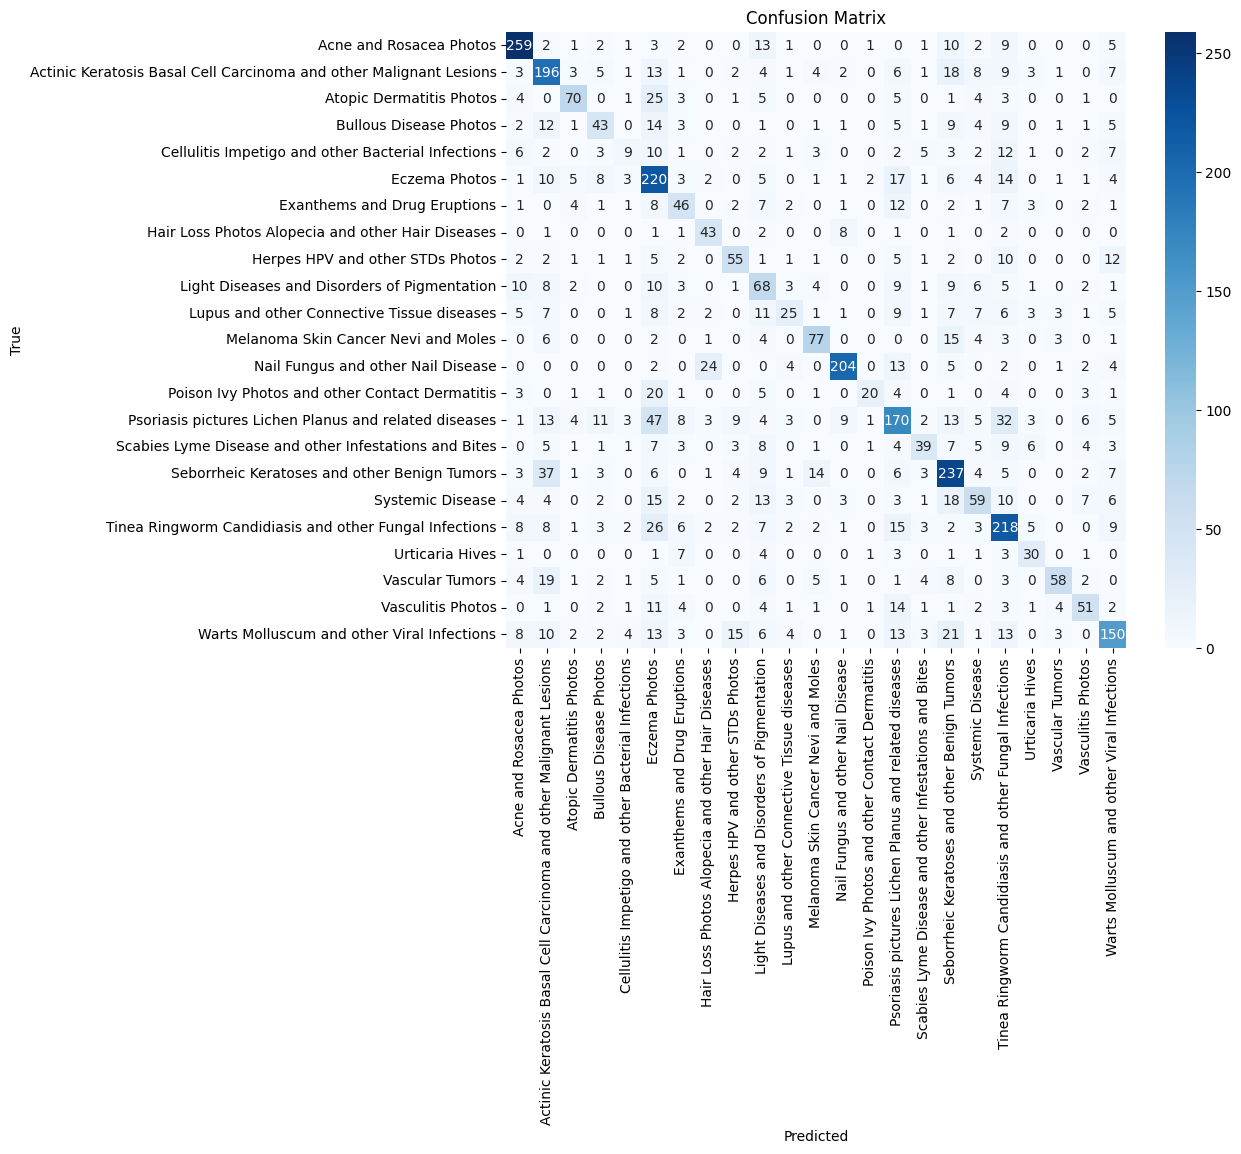

In [4]:
# ✅ Install
!pip install -q transformers torch torchvision scikit-learn seaborn

# ✅ Imports
import torch
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import numpy as np
import os
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ✅ Load DINOv2 Large
processor = AutoImageProcessor.from_pretrained('facebook/dinov2-large')
dino_model = AutoModel.from_pretrained('facebook/dinov2-large').to(device)
dino_model.eval()

# ✅ Feature extractor
def extract_features(img_path):
    image = Image.open(img_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = dino_model(**inputs)
    features = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
    return features

# ✅ Paths
train_dir = '/content/dermnet_data/train'
test_dir = '/content/dermnet_data/test'

# ✅ Map class names
class_names = sorted(os.listdir(train_dir))
class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_names)}
print(f"Classes: {class_names}")

# ✅ Extract & Save Features (only if not saved)
def load_or_extract_features(data_dir, save_prefix):
    X_file = f"{save_prefix}_X.npy"
    y_file = f"{save_prefix}_y.npy"
    if os.path.exists(X_file) and os.path.exists(y_file):
        print(f"Loading saved features from {X_file}")
        X = np.load(X_file)
        y = np.load(y_file)
    else:
        X, y = [], []
        for cls_name in tqdm(os.listdir(data_dir)):
            cls_folder = os.path.join(data_dir, cls_name)
            if not os.path.isdir(cls_folder):
                continue
            label = class_to_idx[cls_name]
            for img_name in os.listdir(cls_folder):
                img_path = os.path.join(cls_folder, img_name)
                try:
                    features = extract_features(img_path)
                    X.append(features)
                    y.append(label)
                except Exception as e:
                    print(f"Skipping {img_path}: {e}")
        X, y = np.array(X), np.array(y)
        np.save(X_file, X)
        np.save(y_file, y)
        print(f"Saved features to {X_file}")
    return X, y

# ✅ Load or extract
X_train, y_train = load_or_extract_features(train_dir, "train")
X_test, y_test = load_or_extract_features(test_dir, "test")

print(f"Train features: {X_train.shape}, Test features: {X_test.shape}")

# ✅ Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# ✅ Datasets and loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# ✅ MLP Classifier
num_classes = len(class_names)
feature_dim = X_train.shape[1]

class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.classifier(x)

model = MLPClassifier(feature_dim, num_classes).to(device)

# ✅ Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ✅ Save/load model functions
model_file = "mlp_classifier.pt"

def save_model():
    torch.save(model.state_dict(), model_file)
    print(f"Saved model to {model_file}")

def load_model():
    model.load_state_dict(torch.load(model_file))
    model.eval()
    print(f"Loaded model from {model_file}")

# ✅ Train
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Train Acc: {acc:.2f}%")

save_model()

# ✅ Test
load_model()
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ✅ Report
print(classification_report(all_labels, all_preds, target_names=class_names))

# ✅ Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


Epoch 1/100, Loss: 0.2190, Train Acc: 92.13%
Epoch 2/100, Loss: 0.2169, Train Acc: 91.99%
Epoch 3/100, Loss: 0.2134, Train Acc: 92.28%
Epoch 4/100, Loss: 0.2061, Train Acc: 92.53%
Epoch 5/100, Loss: 0.2093, Train Acc: 92.64%
Epoch 6/100, Loss: 0.2087, Train Acc: 92.49%
Epoch 7/100, Loss: 0.2006, Train Acc: 92.65%
Epoch 8/100, Loss: 0.1958, Train Acc: 92.92%
Epoch 9/100, Loss: 0.1931, Train Acc: 92.90%
Epoch 10/100, Loss: 0.1906, Train Acc: 93.13%
Epoch 11/100, Loss: 0.1939, Train Acc: 92.90%
Epoch 12/100, Loss: 0.1841, Train Acc: 93.39%
Epoch 13/100, Loss: 0.1800, Train Acc: 93.46%
Epoch 14/100, Loss: 0.1747, Train Acc: 93.73%
Epoch 15/100, Loss: 0.1699, Train Acc: 93.67%
Epoch 16/100, Loss: 0.1793, Train Acc: 93.19%
Epoch 17/100, Loss: 0.1737, Train Acc: 93.78%
Epoch 18/100, Loss: 0.1675, Train Acc: 93.58%
Epoch 19/100, Loss: 0.1771, Train Acc: 93.62%
Epoch 20/100, Loss: 0.1726, Train Acc: 93.53%
Epoch 21/100, Loss: 0.1679, Train Acc: 93.67%
Epoch 22/100, Loss: 0.1666, Train Acc: 93.9

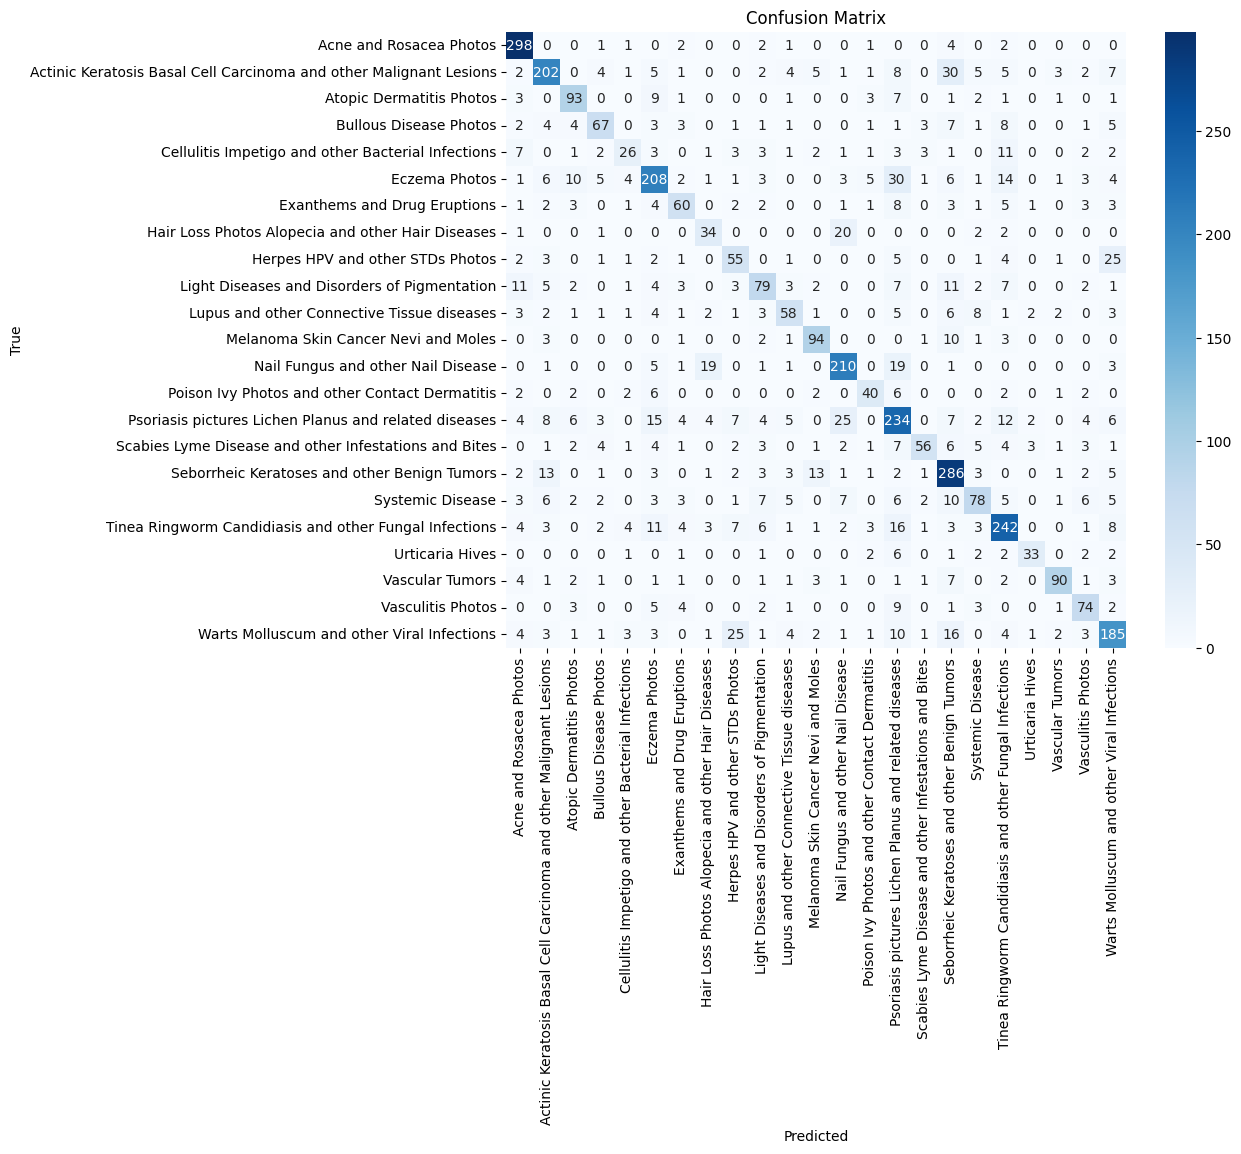

In [6]:
# ✅ Train
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Train Acc: {acc:.2f}%")

save_model()

# ✅ Test
load_model()
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ✅ Report
print(classification_report(all_labels, all_preds, target_names=class_names))

# ✅ Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()